<center><h1>Domain Adaptation</h1></center>

<center><h2><a href="https://arthurdouillard.com/deepcourse/">Course link</a></h2></center>

To keep your modifications in case you want to come back later to this colab, do *File -> Save a copy in Drive*.

We will implement the paper **Unsupervised Domain Adaptation by Backpropagation** in this session. We strongly advise to read this paper, it's a major one!

https://arxiv.org/abs/1409.7495

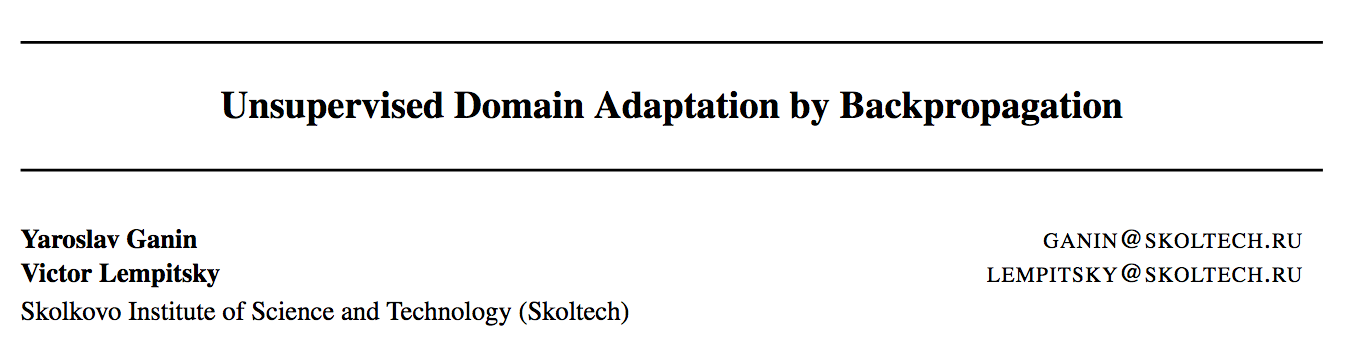

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pickle
import math

import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision
from PIL import Image

In [3]:
torch.__version__

'1.10.1+cu113'

We are going to do a **domain adaptation** from a source dataset (MNIST) towards a target dataset (MNIST-M).

First, we need to create the target dataset:

In [4]:
!wget https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/code/3-c/mnistm.py

--2023-12-26 19:02:48--  https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/code/3-c/mnistm.py
Résolution de proxy.ufr-info-p6.jussieu.fr (proxy.ufr-info-p6.jussieu.fr)… 132.227.118.143, 132.227.118.144
Connexion à proxy.ufr-info-p6.jussieu.fr (proxy.ufr-info-p6.jussieu.fr)|132.227.118.143|:3128… connecté.
requête Proxy transmise, en attente de la réponse… 200 OK
Taille : 2821 (2,8K) [text/plain]
Sauvegarde en : « mnistm.py »

mnistm.py           100%[===================>]   2,75K  --.-KB/s    ds 0s      

2023-12-26 19:02:48 (63,4 MB/s) — « mnistm.py » sauvegardé [2821/2821]



In [5]:
from mnistm import create_mnistm

create_mnistm()

Creating MNIST-M... That may takes a minute
Loading BSR training images


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Building train set...
Processing example 0


/users/nfs/Etu9/21209449/RDFIA/mnistm.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bg_img = rand.choice(background_data)


Processing example 10000
Processing example 20000
Processing example 30000
Processing example 40000
Processing example 50000
Building test set...
Processing example 0
Done!


Then, let's load the MNIST dataset and compute its (train!) mean and standard deviation.

We will use those values to **standardize** both MNIST and MNIST-M.

In [6]:
mnist_pixels = torchvision.datasets.MNIST('.', train=True, download=True).data / 255
mean = mnist_pixels.mean().item()
std = mnist_pixels.std().item()

print(f"Mean {mean} and Std {std}")
mean = torch.tensor([mean, mean, mean])
std = torch.tensor([std, std, std])

Mean 0.13066047430038452 and Std 0.30810782313346863


Create the loaders for MNIST...

In [7]:
transform = transforms.Compose([
  transforms.ToTensor(),
  lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x, # to replicate mnist from graylevel to rgb
  transforms.Normalize(mean, std)
])

mnist_train = torchvision.datasets.MNIST('.', train=True, transform=transform)
mnist_test = torchvision.datasets.MNIST('.', train=False, transform=transform)

source_train_loader = DataLoader(mnist_train, batch_size=128)
source_test_loader = DataLoader(mnist_test, batch_size=128)

... and visualize!

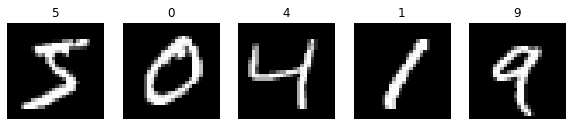

In [8]:
plt.figure(figsize=(10, 7))

for i in range(5):
  ax = plt.subplot(1, 5, i + 1)
  ax.axis('off')

  x, y = mnist_train[i]
  img = ((x * std[:, None, None] + mean[:, None, None]) * 255).permute(1, 2, 0)
  plt.imshow(img.numpy().astype(np.uint8), cmap='gray')
  plt.title(y)

Likewise, for MNIST-M. We create a simple `Dataset` in order to load the dataset that was serialized as a pickle:

In [9]:
with open('mnistm_data.pkl', 'rb') as f:
  mnist_m = pickle.load(f)

class MNISTM(torch.utils.data.Dataset):
  def __init__(self, x, y, transform):
    self.x, self.y = x, y
    self.transform = transform

  def __len__(self):
    return len(self.x)

  def __getitem__(self, index):
    x, y = self.x[index], self.y[index]
    x = self.transform(x)

    return x, y

mnistm_train = MNISTM(mnist_m["x_train"], mnist_m["y_train"], transform)
mnistm_test = MNISTM(mnist_m["x_test"], mnist_m["y_test"], transform)

target_train_loader = DataLoader(mnistm_train, batch_size=128)
target_test_loader = DataLoader(mnistm_test, batch_size=128)

And we also visualize it. Remember to always visualize your data before training a model on it. You may realize that the dataset is ill-formated, in its pixels or targets, and have to do more data preparation beforehand.

Noice that **MNIST-M** is extremely similar to MNIST. The only difference is that the former has colors and textures, and is thus a RGB image. Because MNIST is in grayscale, we have duplicated thrice its channels axis.

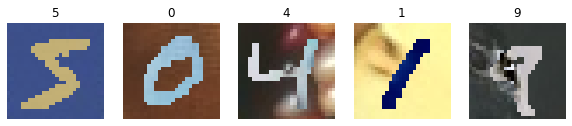

In [10]:
plt.figure(figsize=(10, 7))

for i in range(5):
  ax = plt.subplot(1, 5, i + 1)
  ax.axis('off')

  x, y = mnistm_train[i]
  img = ((x * std[:, None, None] + mean[:, None, None]) * 255).permute(1, 2, 0)
  plt.imshow(img.numpy().astype(np.uint8))
  plt.title(y)

Now, let's implement this basic network, whose figure is extracted from the paper. Conceive your model so that convolutions do not reduce the spatial dimensions:

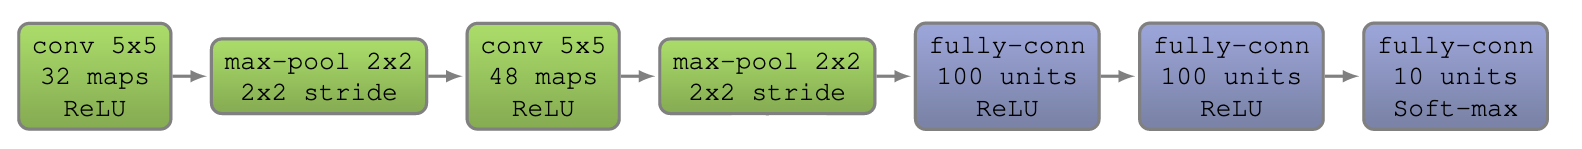

In [11]:
class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()

    def forward(self, x):
        # Do your print / debug stuff here
        print(x.shape)
        return x

In [12]:
class NaiveNet(nn.Module):
  def __init__(self):
    super().__init__()  # Important, otherwise will throw an error

    self.cnn = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5),
    nn.ReLU(),

    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(in_channels=32, out_channels=48, kernel_size=5),
    nn.ReLU(),

    nn.MaxPool2d(kernel_size=2, stride=2),
  )

    self.classif = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=48 * 4 * 4, out_features=100),

    nn.ReLU(),
    nn.Linear(in_features=100, out_features=100),

    nn.ReLU(),
    nn.Linear(in_features=100, out_features=10)
    # no softmax because we use cross entropy loss
  )

  def forward(self, x):
    self.features = self.cnn(x)
    x = self.classif(self.features)
    return x


NaiveNet()(torch.randn(2, 3, 28, 28)).shape

torch.Size([2, 10])

In [13]:
def eval_model(net, loader):
  net.eval()

  acc, loss = 0, 0.
  c = 0
  for x, y in loader:
    c += len(x)

    with torch.no_grad():
      logits = net(x.cuda()).cpu()

    loss += F.cross_entropy(logits, y).item()
    acc += (logits.argmax(dim=1) == y).sum().item()

  return round(100 * acc / c, 2), round(loss / len(loader), 5)

Let's train our naive model, but only the source (MNIST) dataset. We will evaluate its performance on the target (MNIST-M) dataset afterwards.

Notice that we use a **learning rate scheduler**. We are updating the learning rate after each epoch according to a function defined with a *lambda* following the paper specification.

We set the initial learning rate to 1.0 because `LambdaLR` defines a *multiplicative factor* of the base learning rate.

It's often useful to reduce likewise the learning rate during training, to facilitate convergence once the model has found a good local minima (we rarely find the global).

In [14]:
epochs = 10

naive_net = NaiveNet().cuda()

optimizer = torch.optim.SGD(naive_net.parameters(), lr=1.0, momentum=0.9)

mu0, alpha, beta = 0.01, 10, 0.75
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda e: 0.01 / (1 + alpha * e / epochs) ** beta
)

for epoch in range(epochs):
  train_loss = 0.

  for x, y in source_train_loader:
    x, y = x.cuda(), y.cuda()

    optimizer.zero_grad()
    logits = naive_net(x)
    loss = F.cross_entropy(logits, y)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
  print(f'Epoch {epoch}, train loss: {round(train_loss / len(source_train_loader), 5)}')
  scheduler.step()
  print(f"\tLearning rate = {optimizer.param_groups[0]['lr']}")

test_acc, test_loss = eval_model(naive_net, source_test_loader)
print(f"Test loss: {test_loss}, test acc: {test_acc}")

Epoch 0, train loss: 0.36307
	Learning rate = 0.005946035575013606
Epoch 1, train loss: 0.06087
	Learning rate = 0.004386913376508308
Epoch 2, train loss: 0.04262
	Learning rate = 0.0035355339059327372
Epoch 3, train loss: 0.03429
	Learning rate = 0.002990697562442441
Epoch 4, train loss: 0.02911
	Learning rate = 0.0026084743001221454
Epoch 5, train loss: 0.02547
	Learning rate = 0.002323680802425408
Epoch 6, train loss: 0.02271
	Learning rate = 0.0021022410381342864
Epoch 7, train loss: 0.02045
	Learning rate = 0.0019245008972987524
Epoch 8, train loss: 0.01857
	Learning rate = 0.0017782794100389228
Epoch 9, train loss: 0.01698
	Learning rate = 0.0016556002607617019
Test loss: 0.02965, test acc: 98.97


Performance onn less than 10 epochs are great on MNIST, more than 99% accuracy! But this dataset is quite easy.

Now, the real question is: can our model generalize on the slightly different domain of MNIST-M?

In [15]:
test_acc, test_loss = eval_model(naive_net, target_test_loader)
print(f"Test loss: {test_loss}, test acc: {test_acc}")

Test loss: 1.35131, test acc: 54.19


No... You should have an accuracy of 53 to 57%, far less than the 99% we had.

We are going to implement **DANN**, the **Domain Adverserial Neural Network**. The key part of this network is its domain prediction branch and its **gradient reversal layer** (GRL).

The GRL will reverse the gradient between the domain classifier (in pink) and the features extractor (in green).

What does it mean intuitively? The gradient of the domain classifier should help to better classify the domain. Therefore if we reverse it before the end of the features extractor, we will force this CNN to do the opposite: to make the features as agnostic as possible from the domain. Which would mean that the features of MNIST and MNIST-M will be similar and only the digit info will be kept.

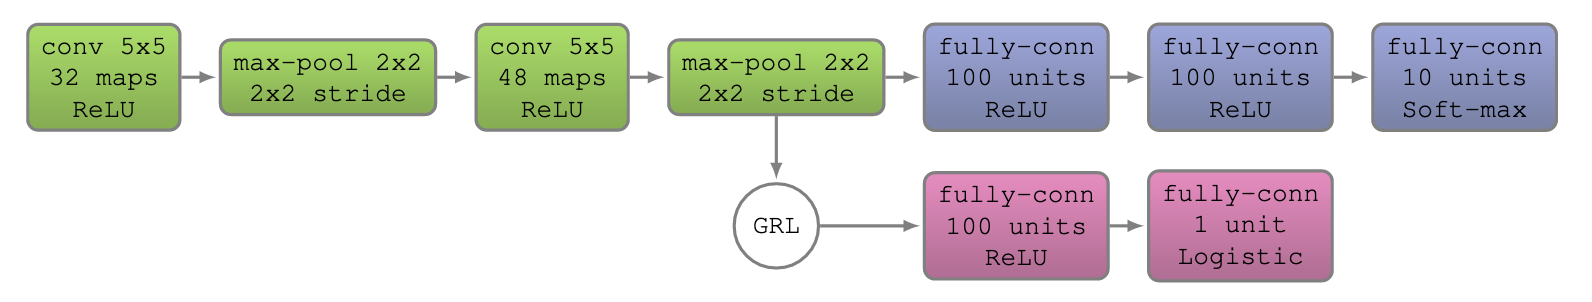

To code a custom backward in PyTorch, you need to define a `torch.autograd.Function`.

The forward is easy, we do nothing except storing a factor that we will need in the backward pass.

In the backward pass we need to return as much gradients as there are inputs (here two). Because the factor is not something to be optimized, we return `None`.

Now, given the factor (which is defaulted to -1, aka "reverse"), define the modified gradient:



In [16]:
class GradientReversal(torch.autograd.Function):
  @staticmethod
  def forward(ctx, x, factor=-1):
    ctx.save_for_backward(torch.tensor(factor))
    return x

  @staticmethod
  def backward(ctx, grad):
    factor, = ctx.saved_tensors

    reversed_grad = factor * grad

    return reversed_grad, None

In [17]:
x = torch.tensor([42.], requires_grad=True)
y = torch.tensor([1337.], requires_grad=True)
o = x * y
o.backward()
print(x.grad.item())

x = torch.tensor([42.], requires_grad=True)
y = torch.tensor([1337.], requires_grad=True)
o = GradientReversal.apply(x * y, -1)
o.backward()
print(x.grad.item())

1337.0
-1337.0


To use a PyTorch's `Function`, call its apply

Now, code the DANN. You can re-use parts of the code you wrote for the naive model.

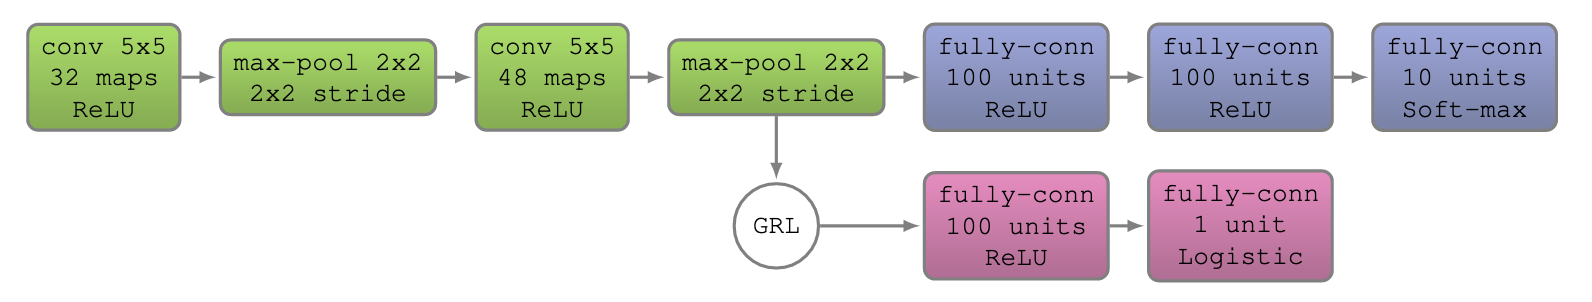

In [32]:
class DANN(nn.Module):
  def __init__(self, activation: str = "sigmoid"):
    super().__init__()  # Important, otherwise will throw an error

    self.cnn = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5),
    nn.ReLU(),

    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(in_channels=32, out_channels=48, kernel_size=5),
    nn.ReLU(),

    nn.MaxPool2d(kernel_size=2, stride=2),

    # ReLU / Sigmoid
    nn.Sigmoid() if activation == "sigmoid" else nn.ReLU()
  )

    self.classif = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=48 * 4 * 4, out_features=100),

    nn.ReLU(),
    nn.Linear(in_features=100, out_features=100),

    nn.ReLU(),
    nn.Linear(in_features=100, out_features=10),
    # no softmax because we use cross entropy loss

  )

    self.domain = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=48 * 4 * 4, out_features=100),

    nn.ReLU(),
    nn.Linear(in_features=100, out_features=1)
    # no softmax because we use binary cross entropy loss

  )

  def forward(self, x, factor=-1):
    #TODO
    self.features = self.cnn(x)
    # x.shape -> 128
    # 64 -> Gray 64 -> RGB
    class_pred = self.classif(self.features)
    features_r = GradientReversal.apply(self.features, factor)
    domain_pred = self.domain(features_r)

    # domain_pred_s, domain_pred_t = domain_pred.chunk(2, dim=0)
    # domain_pred_tt = GradientReversal.apply(domain_pred_t, factor)
    # domain_pred_all = torch.cat([domain_pred_s, domain_pred_tt], dim=0)

    return class_pred, domain_pred


In [19]:
def eval_dann(net, loader, source=True):
  net.eval()

  c_acc, d_acc, cls_loss, d_loss = 0, 0, 0., 0.
  c = 0
  for x, y in loader:
    x = x.cuda()
    if source:
      d = torch.ones(len(x))
    else:
      d = torch.zeros(len(x))

    c += len(x)

    with torch.no_grad():
      cls_logits, domain_logits = net(x.cuda())
      cls_logits, domain_logits = cls_logits.cpu(), domain_logits.cpu()

    cls_loss += F.cross_entropy(cls_logits, y).item()
    d_loss += F.binary_cross_entropy_with_logits(domain_logits[:, 0], d).item()

    c_acc += (cls_logits.argmax(dim=1) == y).sum().item()
    d_acc += ((torch.sigmoid(domain_logits[:, 0]) > 0.5).float() == d).sum().item()

  return round(100 * c_acc / c, 2), round(100 * d_acc / c, 2), round(cls_loss / len(loader), 5), round(d_loss / len(loader), 5)

In [20]:
source_train_loader = DataLoader(mnist_train, batch_size=64)
target_train_loader = DataLoader(mnistm_train, batch_size=64)

len(source_train_loader), len(target_train_loader)

(938, 938)

For the GRL, using directly a factor -1 will results in very bad performance. Therefore we are going to grow the factor gradually during training (deep learning is an art!).

Here is a plot of the function we will use (note that it is a modified version from the paper):

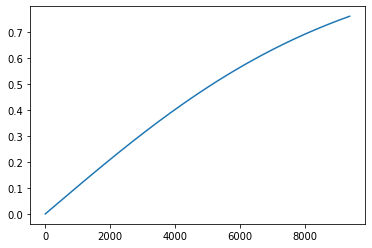

In [21]:
nb_iters = (len(source_train_loader) * epochs)

x = [i for i in range(nb_iters)]
lmbd = lambda e: -1 + 2 / (1 + math.exp(-2 * e / nb_iters))
y = [lmbd(i) for i in x]

plt.plot(x, y)


Let's train our DANN. The GRL factor will be updated after each batch.

Remember that we are not allowed to use the labels of MNIST-M as we assume this dataset is **unlabeled**.

My comment:
From the main paper, "For loss functions, we set Ly and Ld to be the logistic regression loss and the binomial cross-entropy respectively."

In [22]:
epochs = 20

dann = DANN().cuda()

optimizer = torch.optim.SGD(dann.parameters(), lr=0.3, momentum=0.9)

mu0, alpha, beta = 0.01, 10, 0.75
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda e: 0.01 / (1 + alpha * e / epochs) ** beta
)
lmbd = lambda e: -1 + 2 / (1 + math.exp(-2 * e / (len(source_train_loader) * epochs)))

b = 0
for epoch in range(epochs):
  cls_loss, domain_loss = 0., 0.
  grl_factor = lmbd(b)
  print(f"GRL factor {grl_factor}" )

  for (xs, ys), (xt, _) in zip(source_train_loader, target_train_loader):
    grl_factor = lmbd(b)
    b += 1

    batch_size = xs.shape[0] # 64

    xs, ys = xs.cuda(), ys.cuda()
    xt = xt.cuda()
    x = torch.cat((xs, xt), dim=0)

    optimizer.zero_grad()
    cls_logits, domain_logits = dann(x, factor=-grl_factor)

    yhat_s, yhat_t = cls_logits.chunk(2, dim=0)
    # xhat_s, xhat_t = domain_logits.chunk(2, dim=0)

    domain_logits_labels = torch.cat((torch.ones(batch_size, 1), torch.zeros(batch_size, 1)), dim=0).cuda()

    ce = nn.CrossEntropyLoss()  # For classification loss TODO
    ce = ce(yhat_s, ys)
    bce = nn.BCEWithLogitsLoss()  # For binary cross-entropy loss TODO
    bce = bce(domain_logits, domain_logits_labels) # [64 -> 1, 64 -> 0]
    loss = ce + bce * 0.6
    loss.backward()
    optimizer.step()

    cls_loss += ce.item()
    domain_loss += bce.item()

  cls_loss = round(cls_loss / len(source_train_loader), 5)
  domain_loss = round(domain_loss / (2 * len(source_train_loader)), 5)
  print(f'Epoch {epoch}, class loss: {cls_loss}, domain loss: {domain_loss}')
  scheduler.step()

c_acc, d_acc, c_loss, d_loss = eval_dann(dann, source_test_loader)
print(f"[SOURCE] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

c_acc, d_acc, c_loss, d_loss = eval_dann(dann, target_test_loader, source=False)
print(f"[TARGET] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

GRL factor 0.0
Epoch 0, class loss: 0.42911, domain loss: 0.1291
GRL factor 0.049958374957880025
Epoch 1, class loss: 0.07604, domain loss: 0.10388
GRL factor 0.0996679946249559
Epoch 2, class loss: 0.05422, domain loss: 0.092
GRL factor 0.14888503362331806
Epoch 3, class loss: 0.04529, domain loss: 0.11895
GRL factor 0.197375320224904
Epoch 4, class loss: 0.03813, domain loss: 0.11461
GRL factor 0.2449186624037092
Epoch 5, class loss: 0.03385, domain loss: 0.1074
GRL factor 0.2913126124515908
Epoch 6, class loss: 0.03131, domain loss: 0.10938
GRL factor 0.3363755443363323
Epoch 7, class loss: 0.02952, domain loss: 0.11066
GRL factor 0.379948962255225
Epoch 8, class loss: 0.0285, domain loss: 0.11363
GRL factor 0.4218990052500078
Epoch 9, class loss: 0.02917, domain loss: 0.11904
GRL factor 0.4621171572600098
Epoch 10, class loss: 0.0306, domain loss: 0.12444
GRL factor 0.5005202111902354
Epoch 11, class loss: 0.0282, domain loss: 0.12473
GRL factor 0.5370495669980351
Epoch 12, class l

We should see a huge gain, from the ~55% of accuracy on MNIST-M to more than 73% of accuracy without ever seeing labels of MNIST-M.

This is a very nice gain. Let's now verify visualy that our features space is indeed agnostic to the domain:

In [23]:
def extract_emb(net, loader):
  embeddings = []

  for x, _ in loader:
    with torch.no_grad():
      feats = net.cnn(x.cuda()).view(len(x), -1).cpu()

    embeddings.append(feats.numpy())

  return np.concatenate(embeddings)

We use **TSNE** to visualize the embeddings. As you can guess, a human cannot comprehend a space of hundred of dimensions, thus TSNE can project this space onto a space of 2 dimensions.

But beware of the several drawbacks of TSNE:
- **it is super slow**, so we will compute it on a subset of the data
- **it is not determinist**, so you can have different results everytime
- **it can be tuned**, and as everything that can be tuned, you can "*force*" it to take some aspect that you wish it has, while not being really representative of the real data

If you want to learn more about TSNE, head off to this fantastic website: https://distill.pub/2016/misread-tsne/

In [24]:
from sklearn.manifold import TSNE

Original embeddings of source / target (60000, 768) (60000, 768)
Samples embeddings (2000, 768) (2000,)


/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Dimension reduced embeddings (2000, 2)


Text(0.5, 1.0, 'Without domain adaptation')

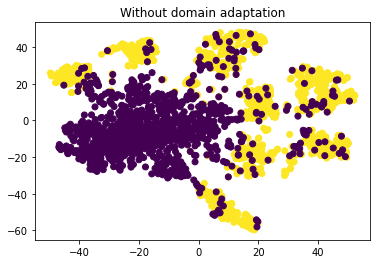

In [25]:
source_emb = extract_emb(naive_net, source_train_loader)
target_emb = extract_emb(naive_net, target_train_loader)

print("Original embeddings of source / target", source_emb.shape, target_emb.shape)

indexes = np.random.permutation(len(source_emb))[:1000]

emb = np.concatenate((source_emb[indexes], target_emb[indexes]))
domains = np.concatenate((np.ones((1000,)), np.zeros((1000,))))

print("Samples embeddings", emb.shape, domains.shape)

tsne = TSNE(n_components=2)

emb_2d = tsne.fit_transform(emb)
print("Dimension reduced embeddings", emb_2d.shape)

plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=domains)
plt.title("Without domain adaptation")

Yellow dots are the source (MNIST) dataset, while purple dots are the target dataset (MNIST-M). We can clearly see that they belong to different space if we use the naive model.

Original embeddings of source / target (60000, 768) (60000, 768)
Samples embeddings (2000, 768) (2000,)


/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Dimension reduced embeddings (2000, 2)


Text(0.5, 1.0, 'With domain adaptation')

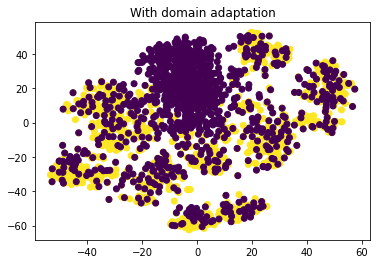

In [26]:
source_emb = extract_emb(dann, source_train_loader)
target_emb = extract_emb(dann, target_train_loader)

print("Original embeddings of source / target", source_emb.shape, target_emb.shape)

indexes = np.random.permutation(len(source_emb))[:1000]

emb = np.concatenate((source_emb[indexes], target_emb[indexes]))
domains = np.concatenate((np.ones((1000,)), np.zeros((1000,))))

print("Samples embeddings", emb.shape, domains.shape)

tsne = TSNE(n_components=2)

emb_2d = tsne.fit_transform(emb)
print("Dimension reduced embeddings", emb_2d.shape)

plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=domains)
plt.title("With domain adaptation")

But with our DANN, while still imperfect, the two domains are much more merged. This confirm our intuition that the GRL forces the network to produce domain-agnostic features.

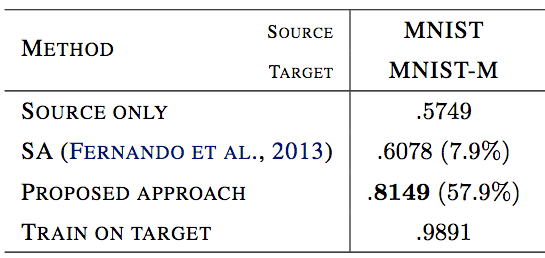

Our model is still lower than the performance reported in the original paper. You can try to further improve it by:

- use much more epochs
- modify the learning rate scheduler to be updated per step
- test different standardization
- different GRL factor scheduling

In [36]:
def train(epochs=20, lr=0.6, alpha=10, beta=0.75, activation='sigmoid'):
    dann = DANN(activation).cuda()

    optimizer = torch.optim.SGD(dann.parameters(), lr=lr, momentum=0.9)
    
    scheduler = torch.optim.lr_scheduler.LambdaLR(
        optimizer,
        lambda e: 0.01 / (1 + alpha * e / epochs) ** beta
    )
    lmbd = lambda e: -1 + 2 / (1 + math.exp(-2 * e / (len(source_train_loader) * epochs)))

    b = 0
    for epoch in range(epochs):
        cls_loss, domain_loss = 0., 0.
        grl_factor = lmbd(b)
        print(f"GRL factor {grl_factor}" )

        for (xs, ys), (xt, _) in zip(source_train_loader, target_train_loader):
            grl_factor = lmbd(b)
            b += 1

            batch_size = xs.shape[0] # 64

            xs, ys = xs.cuda(), ys.cuda()
            xt = xt.cuda()
            x = torch.cat((xs, xt), dim=0)

            optimizer.zero_grad()
            cls_logits, domain_logits = dann(x, factor=-grl_factor)

            yhat_s, yhat_t = cls_logits.chunk(2, dim=0)
            # xhat_s, xhat_t = domain_logits.chunk(2, dim=0)

            domain_logits_labels = torch.cat((torch.ones(batch_size, 1), torch.zeros(batch_size, 1)), dim=0).cuda()

            ce = nn.CrossEntropyLoss()  # For classification loss TODO
            ce = ce(yhat_s, ys)
            bce = nn.BCEWithLogitsLoss()  # For binary cross-entropy loss TODO
            bce = bce(domain_logits, domain_logits_labels) # [64 -> 1, 64 -> 0]
            loss = ce + bce * 0.6
            loss.backward()
            optimizer.step()

            cls_loss += ce.item()
            domain_loss += bce.item()

        cls_loss = round(cls_loss / len(source_train_loader), 5)
        domain_loss = round(domain_loss / (2 * len(source_train_loader)), 5)
        print(f'Epoch {epoch}, class loss: {cls_loss}, domain loss: {domain_loss}')
        scheduler.step()

    c_acc, d_acc, c_loss, d_loss = eval_dann(dann, source_test_loader)
    print(f"[SOURCE] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

    c_acc, d_acc, c_loss, d_loss = eval_dann(dann, target_test_loader, source=False)
    print(f"[TARGET] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

    source_emb = extract_emb(dann, source_train_loader)
    target_emb = extract_emb(dann, target_train_loader)

    print("Original embeddings of source / target", source_emb.shape, target_emb.shape)

    indexes = np.random.permutation(len(source_emb))[:1000]

    emb = np.concatenate((source_emb[indexes], target_emb[indexes]))
    domains = np.concatenate((np.ones((1000,)), np.zeros((1000,))))

    print("Samples embeddings", emb.shape, domains.shape)

    tsne = TSNE(n_components=2)

    emb_2d = tsne.fit_transform(emb)
    print("Dimension reduced embeddings", emb_2d.shape)

    plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=domains)
    plt.title("With domain adaptation")
    plt.show()
    

GRL factor 0.0
Epoch 0, class loss: 0.97572, domain loss: 0.23314
GRL factor 0.0996679946249559
Epoch 1, class loss: 0.15981, domain loss: 0.21358
GRL factor 0.197375320224904
Epoch 2, class loss: 0.11267, domain loss: 0.24159
GRL factor 0.2913126124515908
Epoch 3, class loss: 0.09364, domain loss: 0.25314
GRL factor 0.379948962255225
Epoch 4, class loss: 0.08376, domain loss: 0.25038
GRL factor 0.4621171572600098
Epoch 5, class loss: 0.07737, domain loss: 0.25794
GRL factor 0.5370495669980351
Epoch 6, class loss: 0.07185, domain loss: 0.24736
GRL factor 0.6043677771171634
Epoch 7, class loss: 0.06783, domain loss: 0.24985
GRL factor 0.6640367702678489
Epoch 8, class loss: 0.06694, domain loss: 0.25566
GRL factor 0.7162978701990246
Epoch 9, class loss: 0.06605, domain loss: 0.26034
[SOURCE] Class loss/acc: 0.06152 / 98.09%, Domain loss/acc: 0.46282 / 82.9%
[TARGET] Class loss/acc: 1.51744 / 64.22%, Domain loss/acc: 0.60104 / 64.95%
Original embeddings of source / target (60000, 768) (6

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Dimension reduced embeddings (2000, 2)


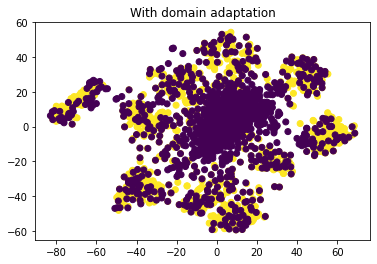

In [37]:
train(epochs=10, lr=0.5, alpha=10, beta=0.75, activation='sigmoid')

GRL factor 0.0
Epoch 0, class loss: 0.98585, domain loss: 0.18858
GRL factor 0.049958374957880025
Epoch 1, class loss: 0.15301, domain loss: 0.20532
GRL factor 0.0996679946249559
Epoch 2, class loss: 0.10449, domain loss: 0.23691
GRL factor 0.14888503362331806
Epoch 3, class loss: 0.08457, domain loss: 0.24753
GRL factor 0.197375320224904
Epoch 4, class loss: 0.07357, domain loss: 0.23925
GRL factor 0.2449186624037092
Epoch 5, class loss: 0.0657, domain loss: 0.23188
GRL factor 0.2913126124515908
Epoch 6, class loss: 0.05946, domain loss: 0.224
GRL factor 0.3363755443363323
Epoch 7, class loss: 0.05464, domain loss: 0.21746
GRL factor 0.379948962255225
Epoch 8, class loss: 0.05232, domain loss: 0.22001
GRL factor 0.4218990052500078
Epoch 9, class loss: 0.05014, domain loss: 0.21728
GRL factor 0.4621171572600098
Epoch 10, class loss: 0.0489, domain loss: 0.22206
GRL factor 0.5005202111902354
Epoch 11, class loss: 0.0492, domain loss: 0.22665
GRL factor 0.5370495669980351
Epoch 12, class

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Dimension reduced embeddings (2000, 2)


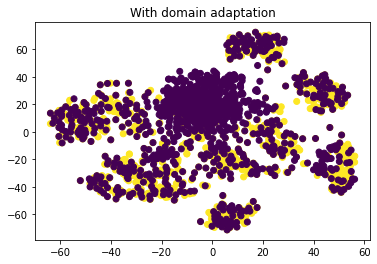

In [38]:
train(epochs=20, lr=0.5, alpha=10, beta=0.75, activation='sigmoid')

GRL factor 0.0
Epoch 0, class loss: 2.24941, domain loss: 0.32558
GRL factor 0.0996679946249559
Epoch 1, class loss: 1.47332, domain loss: 0.26556
GRL factor 0.197375320224904
Epoch 2, class loss: 0.71324, domain loss: 0.27465
GRL factor 0.2913126124515908
Epoch 3, class loss: 0.46708, domain loss: 0.25412
GRL factor 0.379948962255225
Epoch 4, class loss: 0.35942, domain loss: 0.25432
GRL factor 0.4621171572600098
Epoch 5, class loss: 0.3014, domain loss: 0.25838
GRL factor 0.5370495669980351
Epoch 6, class loss: 0.26592, domain loss: 0.2683
GRL factor 0.6043677771171634
Epoch 7, class loss: 0.24146, domain loss: 0.27955
GRL factor 0.6640367702678489
Epoch 8, class loss: 0.22399, domain loss: 0.28736
GRL factor 0.7162978701990246
Epoch 9, class loss: 0.20926, domain loss: 0.28744
[SOURCE] Class loss/acc: 0.18203 / 94.87%, Domain loss/acc: 0.52352 / 81.16%
[TARGET] Class loss/acc: 2.10213 / 53.02%, Domain loss/acc: 0.6081 / 60.77%
Original embeddings of source / target (60000, 768) (600

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Dimension reduced embeddings (2000, 2)


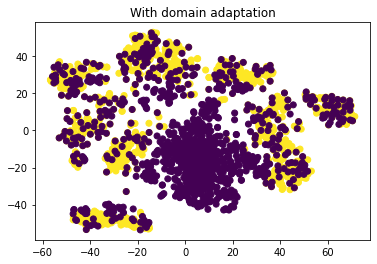

In [39]:
train(epochs=10, lr=0.1, alpha=10, beta=0.75, activation='sigmoid')

GRL factor 0.0
Epoch 0, class loss: 0.65577, domain loss: 0.19496
GRL factor 0.0996679946249559
Epoch 1, class loss: 0.10637, domain loss: 0.21756
GRL factor 0.197375320224904
Epoch 2, class loss: 0.0778, domain loss: 0.23452
GRL factor 0.2913126124515908
Epoch 3, class loss: 0.06592, domain loss: 0.22543
GRL factor 0.379948962255225
Epoch 4, class loss: 0.05816, domain loss: 0.21638
GRL factor 0.4621171572600098
Epoch 5, class loss: 0.05526, domain loss: 0.22178
GRL factor 0.5370495669980351
Epoch 6, class loss: 0.05387, domain loss: 0.22566
GRL factor 0.6043677771171634
Epoch 7, class loss: 0.05326, domain loss: 0.23374
GRL factor 0.6640367702678489
Epoch 8, class loss: 0.05188, domain loss: 0.23443
GRL factor 0.7162978701990246
Epoch 9, class loss: 0.05345, domain loss: 0.24315
[SOURCE] Class loss/acc: 0.05256 / 98.47%, Domain loss/acc: 0.44261 / 85.43%
[TARGET] Class loss/acc: 1.39567 / 67.35%, Domain loss/acc: 0.54522 / 65.28%
Original embeddings of source / target (60000, 768) (6

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Dimension reduced embeddings (2000, 2)


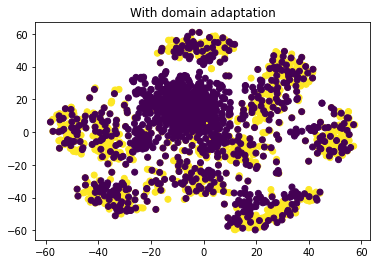

In [40]:
train(epochs=10, lr=1.0, alpha=20, beta=0.75, activation='sigmoid')

GRL factor 0.0
Epoch 0, class loss: 0.33835, domain loss: 0.13308
GRL factor 0.0996679946249559
Epoch 1, class loss: 0.06503, domain loss: 0.10479
GRL factor 0.197375320224904
Epoch 2, class loss: 0.04535, domain loss: 0.11618
GRL factor 0.2913126124515908
Epoch 3, class loss: 0.03802, domain loss: 0.11445
GRL factor 0.379948962255225
Epoch 4, class loss: 0.03483, domain loss: 0.11589
GRL factor 0.4621171572600098
Epoch 5, class loss: 0.03436, domain loss: 0.12064
GRL factor 0.5370495669980351
Epoch 6, class loss: 0.03432, domain loss: 0.12405
GRL factor 0.6043677771171634
Epoch 7, class loss: 0.03374, domain loss: 0.13209
GRL factor 0.6640367702678489
Epoch 8, class loss: 0.03521, domain loss: 0.13776
GRL factor 0.7162978701990246
Epoch 9, class loss: 0.04336, domain loss: 0.16403
[SOURCE] Class loss/acc: 0.04393 / 98.73%, Domain loss/acc: 0.26748 / 91.16%
[TARGET] Class loss/acc: 1.03221 / 66.59%, Domain loss/acc: 0.4098 / 80.47%
Original embeddings of source / target (60000, 768) (6

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Dimension reduced embeddings (2000, 2)


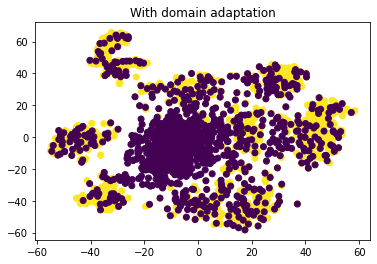

In [41]:
train(epochs=10, lr=0.5, alpha=10, beta=0.75, activation='relu')

GRL factor 0.0
Epoch 0, class loss: 0.3275, domain loss: 0.12968
GRL factor 0.049958374957880025
Epoch 1, class loss: 0.06162, domain loss: 0.08767
GRL factor 0.0996679946249559
Epoch 2, class loss: 0.04293, domain loss: 0.10989
GRL factor 0.14888503362331806
Epoch 3, class loss: 0.03368, domain loss: 0.10699
GRL factor 0.197375320224904
Epoch 4, class loss: 0.02844, domain loss: 0.10006
GRL factor 0.2449186624037092
Epoch 5, class loss: 0.02504, domain loss: 0.10099
GRL factor 0.2913126124515908
Epoch 6, class loss: 0.023, domain loss: 0.10346
GRL factor 0.3363755443363323
Epoch 7, class loss: 0.02275, domain loss: 0.10868
GRL factor 0.379948962255225
Epoch 8, class loss: 0.02262, domain loss: 0.11663
GRL factor 0.4218990052500078
Epoch 9, class loss: 0.02276, domain loss: 0.12099
GRL factor 0.4621171572600098
Epoch 10, class loss: 0.02574, domain loss: 0.1328
GRL factor 0.5005202111902354
Epoch 11, class loss: 0.02692, domain loss: 0.1468
GRL factor 0.5370495669980351
Epoch 12, class

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Dimension reduced embeddings (2000, 2)


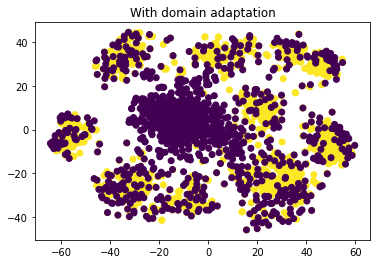

In [42]:
train(epochs=20, lr=0.5, alpha=10, beta=0.75, activation='relu')

GRL factor 0.0
Epoch 0, class loss: 0.79443, domain loss: 0.10175
GRL factor 0.0996679946249559
Epoch 1, class loss: 0.15963, domain loss: 0.04742
GRL factor 0.197375320224904
Epoch 2, class loss: 0.12127, domain loss: 0.18461
GRL factor 0.2913126124515908
Epoch 3, class loss: 0.09912, domain loss: 0.19348
GRL factor 0.379948962255225
Epoch 4, class loss: 0.08672, domain loss: 0.16527
GRL factor 0.4621171572600098
Epoch 5, class loss: 0.0791, domain loss: 0.15415
GRL factor 0.5370495669980351
Epoch 6, class loss: 0.0745, domain loss: 0.15232
GRL factor 0.6043677771171634
Epoch 7, class loss: 0.07117, domain loss: 0.15387
GRL factor 0.6640367702678489
Epoch 8, class loss: 0.06878, domain loss: 0.15262
GRL factor 0.7162978701990246
Epoch 9, class loss: 0.06742, domain loss: 0.15372
[SOURCE] Class loss/acc: 0.06089 / 98.09%, Domain loss/acc: 0.16627 / 97.36%
[TARGET] Class loss/acc: 1.47168 / 56.97%, Domain loss/acc: 0.44539 / 77.44%
Original embeddings of source / target (60000, 768) (60

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Dimension reduced embeddings (2000, 2)


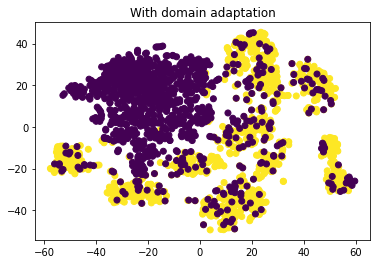

In [43]:
train(epochs=10, lr=0.1, alpha=10, beta=0.75, activation='relu')

GRL factor 0.0
Epoch 0, class loss: 0.23492, domain loss: 0.12275
GRL factor 0.0996679946249559
Epoch 1, class loss: 0.04447, domain loss: 0.0974
GRL factor 0.197375320224904
Epoch 2, class loss: 0.03256, domain loss: 0.12493
GRL factor 0.2913126124515908
Epoch 3, class loss: 0.03092, domain loss: 0.13111
GRL factor 0.379948962255225
Epoch 4, class loss: 0.03444, domain loss: 0.14257
GRL factor 0.4621171572600098
Epoch 5, class loss: 0.03672, domain loss: 0.16166
GRL factor 0.5370495669980351
Epoch 6, class loss: 0.04177, domain loss: 0.18225
GRL factor 0.6043677771171634
Epoch 7, class loss: 0.03508, domain loss: 0.18058
GRL factor 0.6640367702678489
Epoch 8, class loss: 0.05802, domain loss: 0.24949
GRL factor 0.7162978701990246
Epoch 9, class loss: 0.06272, domain loss: 0.26229
[SOURCE] Class loss/acc: 0.06096 / 98.03%, Domain loss/acc: 0.45988 / 76.39%
[TARGET] Class loss/acc: 1.48006 / 57.71%, Domain loss/acc: 0.44218 / 80.99%
Original embeddings of source / target (60000, 768) (6

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Dimension reduced embeddings (2000, 2)


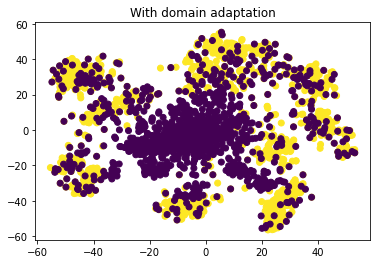

In [44]:
train(epochs=10, lr=1.0, alpha=20, beta=0.75, activation='relu')